# Dataset Preprocessing

In [1]:
# While Model training
# 1. --- Print model summary (trainable, non-trainable, total parameters) 
# 2. --- while compiling the model, add other metrics like roc_auc score, precision, recall,f1-score,specifity,sensivity,accuracy,loss (training and validation both)
# 3. --- Plot metrics curves VS epochs like mentioned in 2 
# 4. --- Plot confusion matrix like training, validation, test dataset 
# 5. --- Implement early stopping with 100 epochs
# 6. --- records total time (training, testing, validation) and also What GPU you are using it.
# 7. ---- Save the models as well ( .hdf5 format for loading the trained weights)
# 8. ---- keep similar loss functions, optimizers, learning rate, epochs, ...etc

In [2]:
!pip install keras tensorflow

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import os

from glob import glob

import seaborn as sns

from PIL import Image

np.random.seed(123)

from sklearn.preprocessing import label_binarize

from sklearn.metrics import confusion_matrix

import itertools

import tensorflow as tf

from tensorflow import keras

from tensorflow.keras.utils import to_categorical # used for converting labels to one-hot-encoding

from keras.models import Sequential

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

from keras import backend as K

import itertools

from keras.layers import BatchNormalization

from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding



from keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split

In [4]:
dataset_path = '/kaggle/input/skin-cancer-mnist-ham10000'

In [5]:
#1. Function to plot model's validation loss and validation accuracy

def plot_model_history(model_history):

    fig, axs = plt.subplots(1,2,figsize=(15,5))

    # summarize history for accuracy

    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])

    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])

    axs[0].set_title('Model Accuracy')

    axs[0].set_ylabel('Accuracy')

    axs[0].set_xlabel('Epoch')

    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)

    axs[0].legend(['train', 'val'], loc='best')

    # summarize history for loss

    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])

    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])

    axs[1].set_title('Model Loss')

    axs[1].set_ylabel('Loss')

    axs[1].set_xlabel('Epoch')

    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)

    axs[1].legend(['train', 'val'], loc='best')

    plt.show()

In [6]:
df = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [8]:
df.shape

(10015, 7)

In [9]:
lesion_type_dict = {

    'nv': 'Melanocytic nevi',

    'mel': 'Melanoma',

    'bkl': 'Benign keratosis-like lesions ',

    'bcc': 'Basal cell carcinoma',

    'akiec': 'Actinic keratoses',

    'vasc': 'Vascular lesions',

    'df': 'Dermatofibroma'

}

base_skin_dir = '/kaggle/input/skin-cancer-mnist-ham10000'

In [10]:
import os

from glob import glob



# Use glob to get a list of file paths

image_paths = glob(os.path.join(base_skin_dir, '*', '*.jpg'))



# Create a dictionary mapping image IDs to file paths

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in image_paths}

In [11]:
df['path'] = df['image_id'].map(imageid_path_dict.get)

df['cell_type'] = df['dx'].map(lesion_type_dict.get)

df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes



df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2


In [12]:
df.isna().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [13]:
df['age'].fillna((df['age'].mean()), inplace=True)

/tmp/ipykernel_23/1123070014.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna((df['age'].mean()), inplace=True)


In [14]:
df.isna().sum().sum()

0

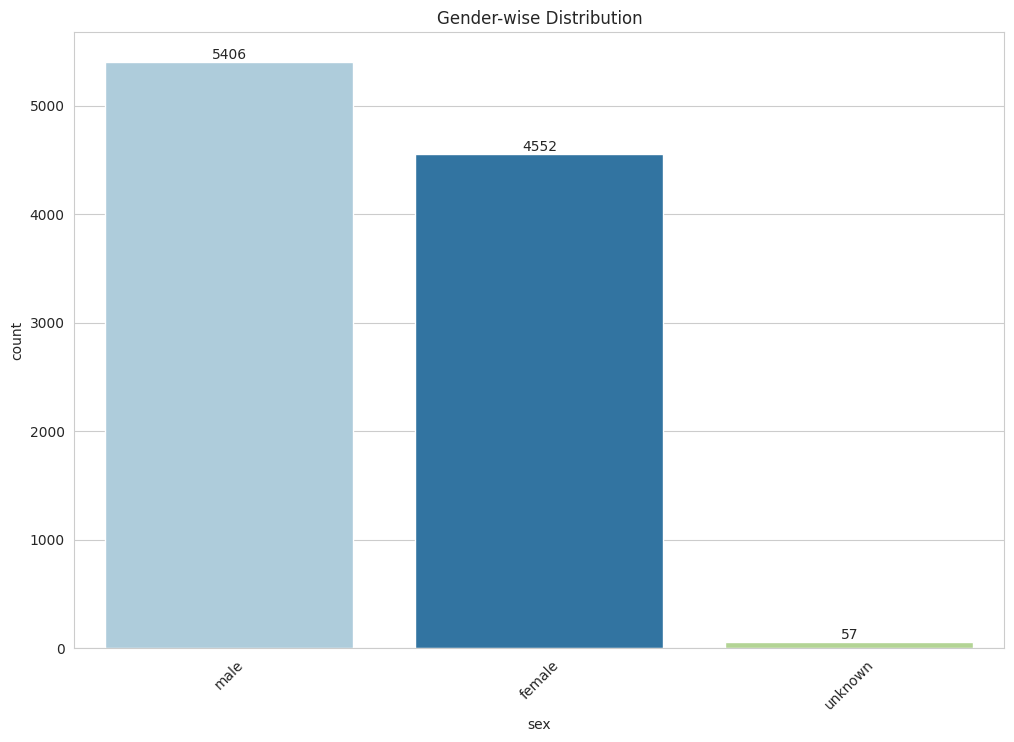

In [15]:
sns.set_style('whitegrid')

colors = ['#87ace8','#e3784d', 'green']

fig,axes = plt.subplots(figsize=(12,8))



ax = sns.countplot(x='sex',data=df, palette = 'Paired')

for container in ax.containers:

    ax.bar_label(container)

plt.title('Gender-wise Distribution')

plt.xticks(rotation=45)

plt.show()

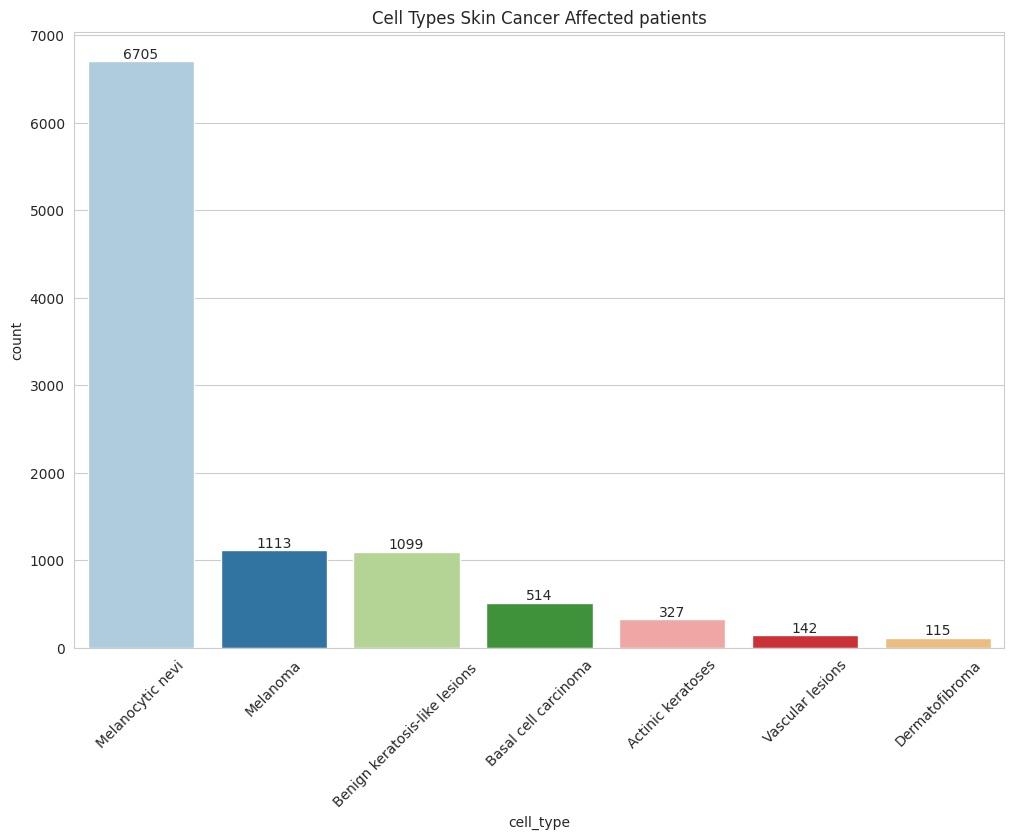

In [16]:
sns.set_style('whitegrid')

fig,axes = plt.subplots(figsize=(12,8))

ax = sns.countplot(x='cell_type',data=df, order = df['cell_type'].value_counts().index, palette = 'Paired')

for container in ax.containers:

    ax.bar_label(container)

plt.title('Cell Types Skin Cancer Affected patients')

plt.xticks(rotation=45)

plt.show()

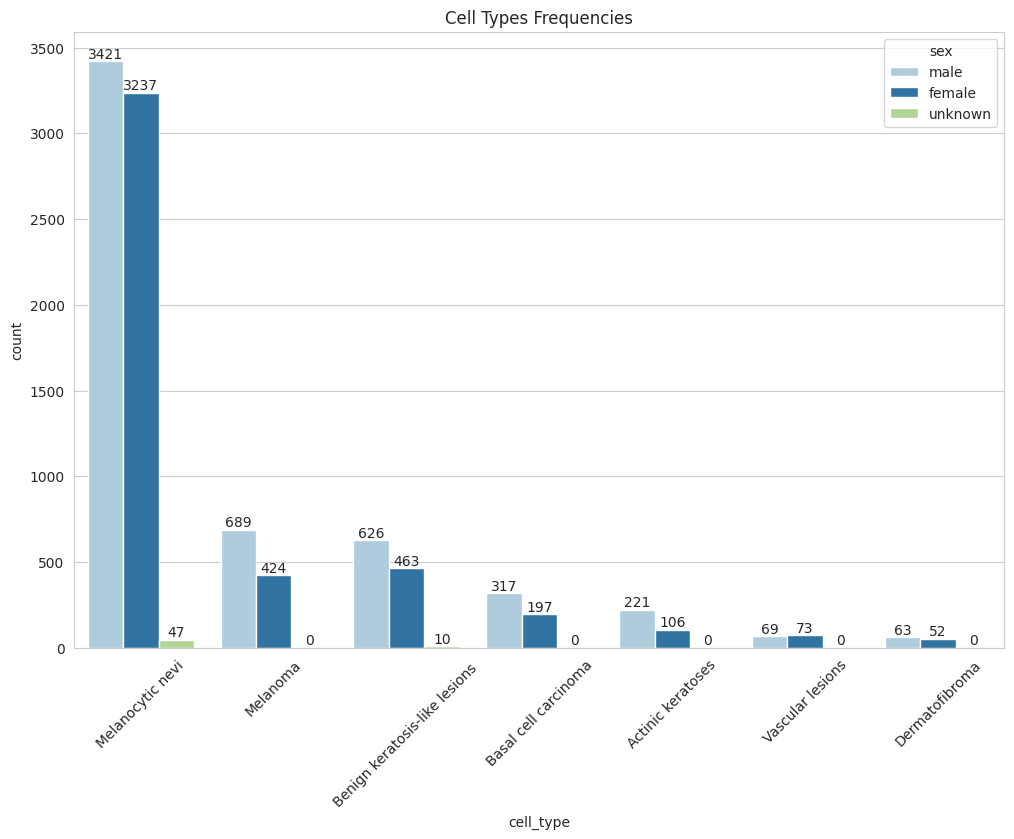

In [17]:
sns.set_style('whitegrid')

fig,axes = plt.subplots(figsize=(12,8))

ax = sns.countplot(x='cell_type',hue='sex', data=df, order = df['cell_type'].value_counts().index, palette = 'Paired')

for container in ax.containers:

    ax.bar_label(container)

plt.title('Cell Types Frequencies')

plt.xticks(rotation=45)

plt.show()

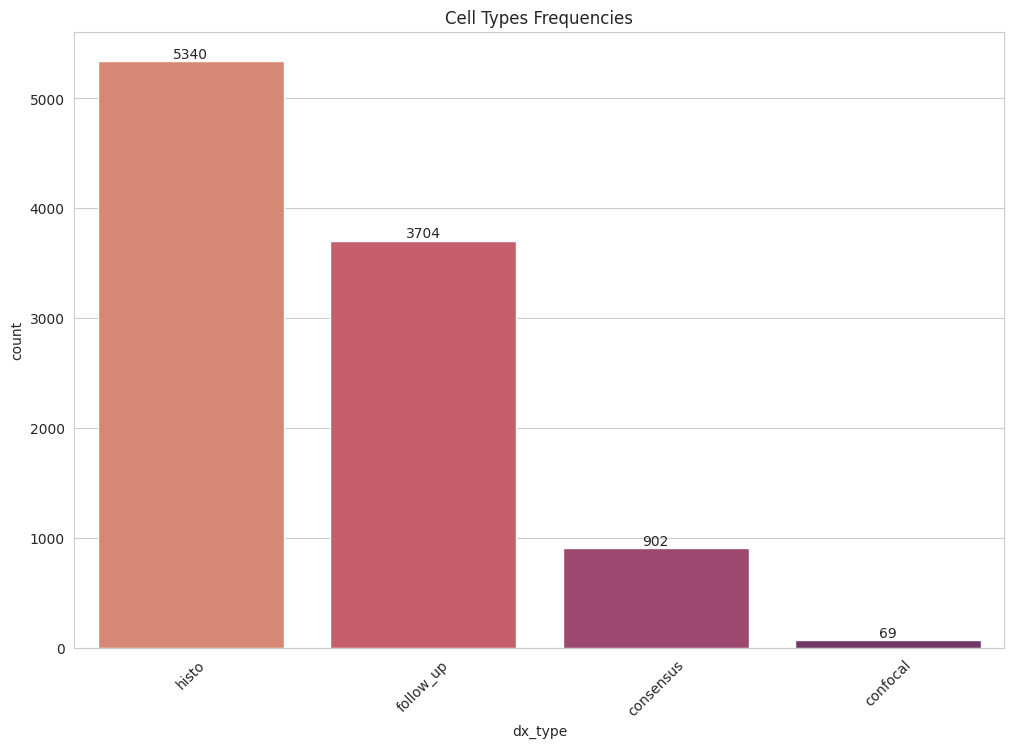

In [18]:
sns.set_style('whitegrid')

fig,axes = plt.subplots(figsize=(12,8))

ax = sns.countplot(x='dx_type',data=df, order = df['dx_type'].value_counts().index, palette = 'flare')

for container in ax.containers:

    ax.bar_label(container)

plt.title('Cell Types Frequencies')

plt.xticks(rotation=45)

plt.show()

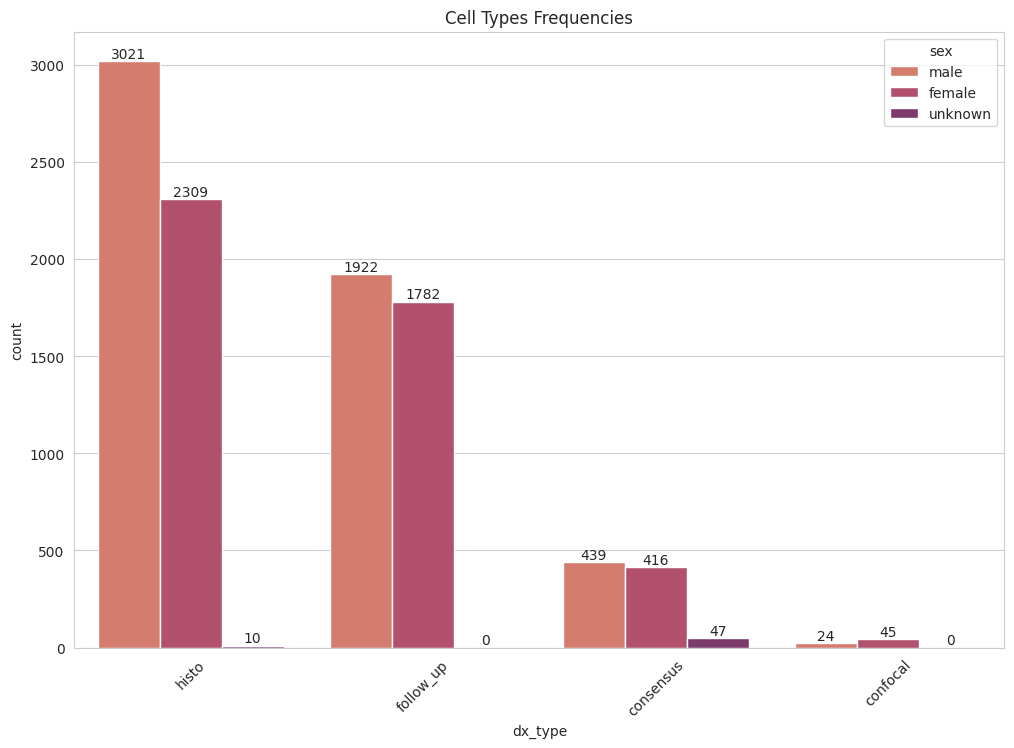

In [19]:
sns.set_style('whitegrid')

fig,axes = plt.subplots(figsize=(12,8))

ax = sns.countplot(x='dx_type',hue='sex', data=df, order = df['dx_type'].value_counts().index, palette = 'flare')

for container in ax.containers:

    ax.bar_label(container)

plt.title('Cell Types Frequencies')

plt.xticks(rotation=45)

plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


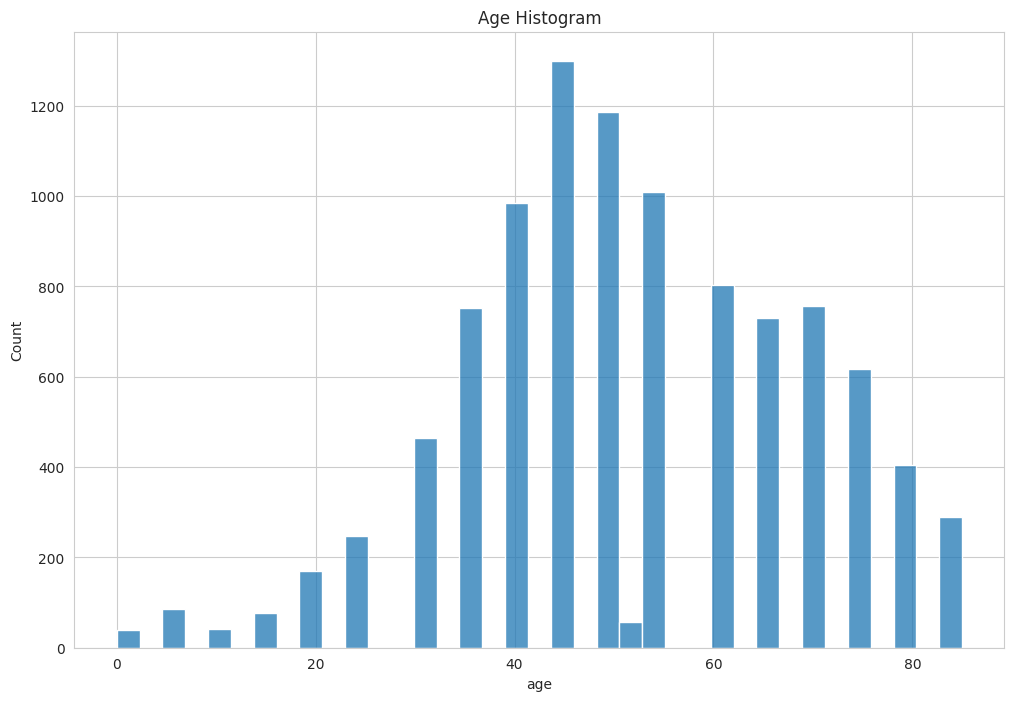

In [20]:
sns.set_style('whitegrid')

fig,axes = plt.subplots(figsize=(12,8))

ax = sns.histplot(data=df, x='age')

plt.title('Age Histogram')

plt.show()

In [21]:
size = (64, 64)

df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize(size))/ 255)

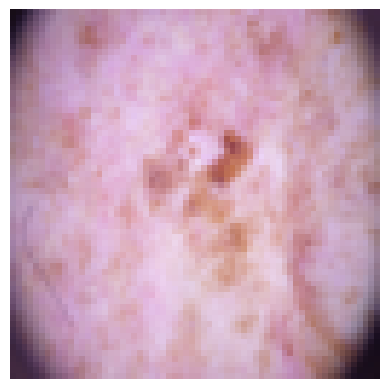

In [22]:
arr = df.iloc[1]['image']

#Image.fromarray(arr)

plt.imshow(arr)

plt.axis('off')

plt.show()

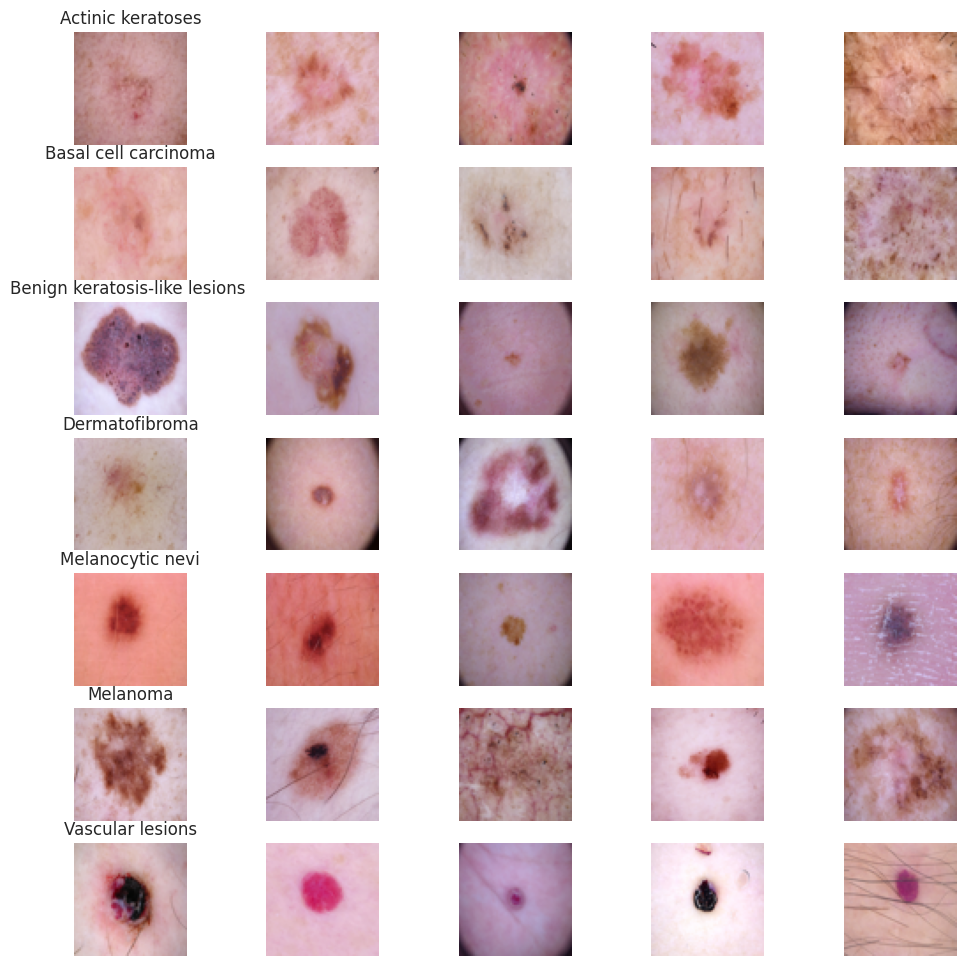

In [23]:
n_samples = 5

fig, m_axs = plt.subplots(7, n_samples, figsize = (12,12))

for n_axs, (type_name, type_rows) in zip(m_axs,

                                         df.sort_values(['cell_type']).groupby('cell_type')):

    n_axs[0].set_title(type_name)

    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=42).iterrows()):

        c_ax.imshow(c_row['image'])

        c_ax.axis('off')

# fig.savefig('category_samples.png', dpi=300)

In [24]:
df['dx'].value_counts()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

In [25]:
def aug_brightness(img_arr):

    aug_arr = tf.image.stateless_random_brightness(img_arr, 0.7, seed)

    aur_arr = np.array(aug_arr)



    return aug_arr

In [26]:
def aug_contrast(img_arr):

    aug_arr = tf.image.stateless_random_contrast(img_arr, 0.2, 0.8, seed)

    aur_arr = np.array(aug_arr)



    return aug_arr

In [27]:
def aug_flip_left_right(img_arr):

    aug_arr = tf.image.stateless_random_flip_left_right(img_arr, seed).numpy().tolist()

    aur_arr = np.array(aug_arr)



    return aug_arr

In [28]:
def aug_flip_up_down(img_arr):

    aug_arr = tf.image.stateless_random_flip_up_down(img_arr, seed).numpy().tolist()

    aur_arr = np.array(aug_arr)



    return aug_arr

In [29]:
def aug_hue(img_arr):

    aug_arr = tf.image.stateless_random_hue(img_arr, 0.5, seed)

    aur_arr = np.array(aug_arr)



    return aug_arr

In [30]:
def aug_saturation(img_arr):

    aug_arr = tf.image.stateless_random_saturation(img_arr, 0.1, 1, seed)

    aur_arr = np.array(aug_arr)



    return aug_arr

In [31]:
func_list = [aug_brightness, aug_contrast, aug_flip_left_right, aug_flip_up_down, aug_hue, aug_saturation]

In [32]:
from IPython.display import clear_output

def random_augmentation(images, dx, num_of_samples):

    new_images = []

    all_indices = []

    while (len(new_images) < num_of_samples):

        indices = np.random.randint(images.shape[0], size=6)

        r = list(map(lambda x, y: x(y), func_list, images.iloc[indices]))

        r = [np.array(tensor) for tensor in r]

        new_images.extend(r)

        all_indices.extend(indices)

        clear_output(wait=True)

        print(str(len(new_images)) + '/' + str(num_of_samples))



    new_images = pd.DataFrame({'dx': dx, 'image': new_images})



    return all_indices, new_images

In [33]:
nv_df = df[df['dx'] == 'nv']

df_df = df[df['dx'] == 'df']

vasc_df = df[df['dx'] == 'vasc']

akiec_df = df[df['dx'] == 'akiec']

bcc_df = df[df['dx'] == 'bcc']

bkl_df = df[df['dx'] == 'bkl']

mel_df = df[df['dx'] == 'mel']

In [34]:
seed = (4,2)

In [35]:
max_count = 10000

nv_count = (df['dx'] == 'nv').sum()

mel_count = (df['dx'] == 'mel').sum()

bkl_count = (df['dx'] == 'bkl').sum()

bcc_count = (df['dx'] == 'bcc').sum()

akiec_count = (df['dx'] == 'akiec').sum()

vasc_count = (df['dx'] == 'vasc').sum()

df_count = (df['dx'] == 'df').sum()

In [36]:
df_images = df_df['image']

df_indices, df_new_images = random_augmentation(df_images, 'df', max_count - df_count)

9888/9885


In [37]:
vasc_images = vasc_df['image']

vasc_indices, vasc_new_images = random_augmentation(vasc_images, 'vasc', max_count - vasc_count)

9858/9858


In [38]:
akiec_images = akiec_df['image'] 

akiec_indices, akiec_new_images = random_augmentation(akiec_images, 'akiec', max_count - akiec_count)

9678/9673


In [39]:
bcc_images = bcc_df['image']

bcc_indices, bcc_new_images = random_augmentation(bcc_images, 'bcc', max_count - bcc_count)

9486/9486


In [40]:
bkl_images = bkl_df['image']

bkl_indices, bkl_new_images = random_augmentation(bkl_images, 'bkl', max_count - bkl_count)

8904/8901


In [41]:
mel_images = mel_df['image']

mel_indices, mel_new_images = random_augmentation(mel_images, 'mel', max_count - mel_count)

8892/8887


In [42]:
nv_images = nv_df['image']

nv_indices, nv_new_images = random_augmentation(nv_images, 'nv', max_count - nv_count)

3300/3295


In [43]:
new_images_df = pd.concat([df_new_images, vasc_new_images, akiec_new_images, bcc_new_images, bkl_new_images, mel_new_images, nv_new_images], axis=0).reset_index(drop=True)

aug_df = pd.concat([df, new_images_df], axis=0).reset_index(drop=True)

aug_df = aug_df.sample(frac=1).reset_index(drop=True)

In [44]:
pd.DataFrame(aug_df['dx'].value_counts()).reset_index()

,dx,count
0,mel,10005
1,akiec,10005
2,nv,10005
3,bkl,10003
4,df,10003
5,vasc,10000
6,bcc,10000


In [45]:
aug_df.shape

(70021, 11)

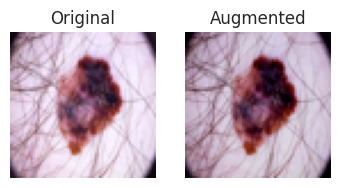

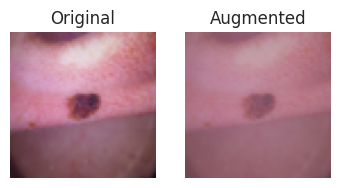

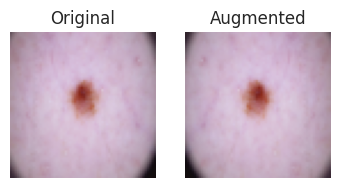

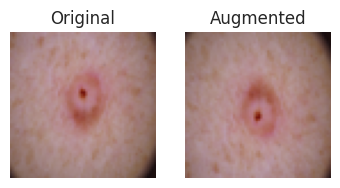

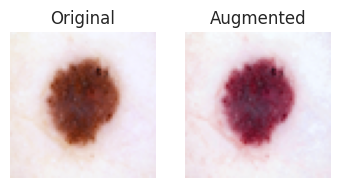

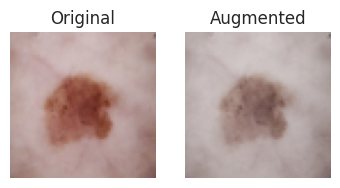

In [46]:
for i in range(12, 18):

    plt.subplot(1, 3, 1)

    plt.imshow(mel_df['image'].iloc[mel_indices[i]])

    plt.title('Original')

    plt.axis('off')



    plt.subplot(1, 3, 2)

    plt.imshow(mel_new_images['image'].iloc[i])

    plt.title('Augmented')

    plt.axis('off')



    plt.show()

In [47]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()

aug_df['label'] = labelEncoder.fit_transform(aug_df['dx'])

In [48]:
x = np.asarray(aug_df['image'].to_list())

y = to_categorical(aug_df['label'], num_classes=7)



x_train, x_test, y_train, y_test = train_test_split(

    x, y, test_size=0.20, random_state=42, shuffle=True, stratify=y

)

# **Model setup**

In [49]:
!pip install -q efficientnet

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [50]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, Input
def create_student_model_with_exits():
    image_size = 64
    num_classes = 7
    input_layer = tf.keras.Input(shape=(image_size, image_size, 3))
    # CNN branch
    cnn_branch = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
    cnn_branch = layers.MaxPooling2D((2, 2))(cnn_branch)
    cnn_branch = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(cnn_branch)
    cnn_branch = layers.MaxPooling2D((2, 2))(cnn_branch)
    cnn_branch = layers.Flatten()(cnn_branch)
    intermediate_output1 = layers.Dense(num_classes, activation='softmax', name='student_exit_1')(cnn_branch)
    # EfficientNet branch
    efficient_net = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3))
    efficient_net.trainable = False
    efficient_net_branch = efficient_net(input_layer)
    efficient_net_branch = layers.GlobalAveragePooling2D()(efficient_net_branch)
    intermediate_output2 = layers.Dense(num_classes, activation='softmax', name='student_exit_2')(efficient_net_branch)
    # Combine branches
    combined = layers.Concatenate()([intermediate_output1, intermediate_output2])
    combined = layers.Dense(256, activation='relu')(combined)
    combined = layers.Dropout(0.5)(combined)
    # Final output layer
    final_output = layers.Dense(num_classes, activation='softmax', name='student_final_output')(combined)
    # Unified model
    student_model = models.Model(inputs=input_layer, outputs=[intermediate_output1, intermediate_output2, final_output])
    return student_model

In [51]:
#Student model
student_model = create_student_model_with_exits()

# Model summary
student_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 2, 2,      │  4,049,571 │ input_layer[0][0] │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8192)      │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ student_exit_1      │ (None, 7)         │     57,351 │ flatten[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ student_exit_2      │ (None, 7)         │      8,967 │ global_average_p… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 14)        │          0 │ student_exit_1[0… │
│ (Concatenate)       │                   │            │ student_exit_2[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │      3,840 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ student_final_outp… │ (None, 7)         │      1,799 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,126,616 (15.74 MB)

 Trainable params: 77,045 (300.96 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [52]:
!pip install pydot graphviz
from tensorflow.keras.utils import plot_model

# Save model architecture as PNG
plot_model(
    student_model,                # Your model
    to_file="Student_model.png",  # File name
    show_shapes=True,             # Display layer shapes
    show_layer_names=True         # Display layer names
)

print("Model summary saved as Student_model.png")

Model summary saved as Student_model.png


In [53]:
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred)
        self.recall.update_state(y_true, y_pred)

    def result(self):
        precision_value = self.precision.result()
        recall_value = self.recall.result()
        return 2 * (precision_value * recall_value) / (precision_value + recall_value + tf.keras.backend.epsilon())

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [54]:
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam

# Compile the model
student_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={
        'student_exit_1': 'categorical_crossentropy',
        'student_exit_2': 'categorical_crossentropy',
        'student_final_output': 'categorical_crossentropy',
    },
    loss_weights={
        'student_exit_1': 1.0,  # Weight for intermediate output 1
        'student_exit_2': 1.0,  # Weight for intermediate output 2
        'student_final_output': 1.0,  # Weight for the final output
    },
    metrics={
        'student_exit_1': [  
        tf.keras.metrics.CategoricalCrossentropy(name='categorical_crossentropy_1',from_logits=False),
        tf.keras.metrics.CategoricalHinge(name='categorical_hinge_1')
    ],
        'student_exit_2': [
        tf.keras.metrics.CategoricalCrossentropy(name='categorical_crossentropy_2',from_logits=False),
        tf.keras.metrics.CategoricalHinge(name='categorical_hinge_2')
    ],
        'student_final_output': ['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='roc_auc'), F1Score(name='f1_score')],
    }
)

In [55]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = student_model.fit(
    x_train,  # Input data
    {
        'student_exit_1': y_train,  # Target for exit 1
        'student_exit_2': y_train,  # Target for exit 2
        'student_final_output': y_train,  # Target for final output
    },
    epochs=100,
    batch_size=32,
    validation_data=(
        x_test,
        {
            'student_exit_1': y_test,
            'student_exit_2': y_test,
            'student_final_output': y_test,
        }
    ),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100


I0000 00:00:1734091248.128092      76 service.cc:145] XLA service 0x78ef34007660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734091248.128148      76 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   9/1751 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - loss: 5.9437 - student_exit_1_categorical_crossentropy_1: 2.0482 - student_exit_1_categorical_hinge_1: 1.1050 - student_exit_2_categorical_crossentropy_2: 1.9538 - student_exit_2_categorical_hinge_2: 1.0680 - student_final_output_accuracy: 0.1570 - student_final_output_f1_score: 0.0000e+00 - student_final_output_precision: 0.0000e+00 - student_final_output_recall: 0.0000e+00 - student_final_output_roc_auc: 0.5276

I0000 00:00:1734091268.506229      76 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1751/1751 ━━━━━━━━━━━━━━━━━━━━ 85s 31ms/step - loss: 5.1183 - student_exit_1_categorical_crossentropy_1: 1.5398 - student_exit_1_categorical_hinge_1: 0.9786 - student_exit_2_categorical_crossentropy_2: 1.9694 - student_exit_2_categorical_hinge_2: 1.0441 - student_final_output_accuracy: 0.3608 - student_final_output_f1_score: 0.2020 - student_final_output_precision: 0.6940 - student_final_output_recall: 0.1238 - student_final_output_roc_auc: 0.7439 - val_loss: 4.2708 - val_student_exit_1_categorical_crossentropy_1: 1.1544 - val_student_exit_1_categorical_hinge_1: 0.8700 - val_student_exit_2_categorical_crossentropy_2: 1.9585 - val_student_exit_2_categorical_hinge_2: 1.0353 - val_student_final_output_accuracy: 0.5714 - val_student_final_output_f1_score: 0.5211 - val_student_final_output_precision: 0.6986 - val_student_final_output_recall: 0.4155 - val_student_final_output_roc_auc: 0.8870 - learning_rate: 0.0010
Epoch 2/100
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - loss: 4.1118 - stu

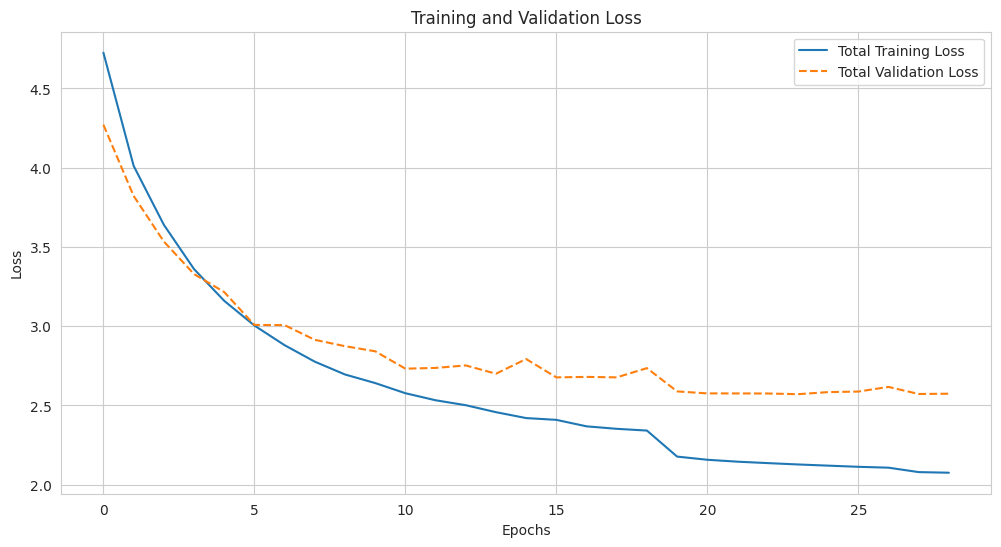

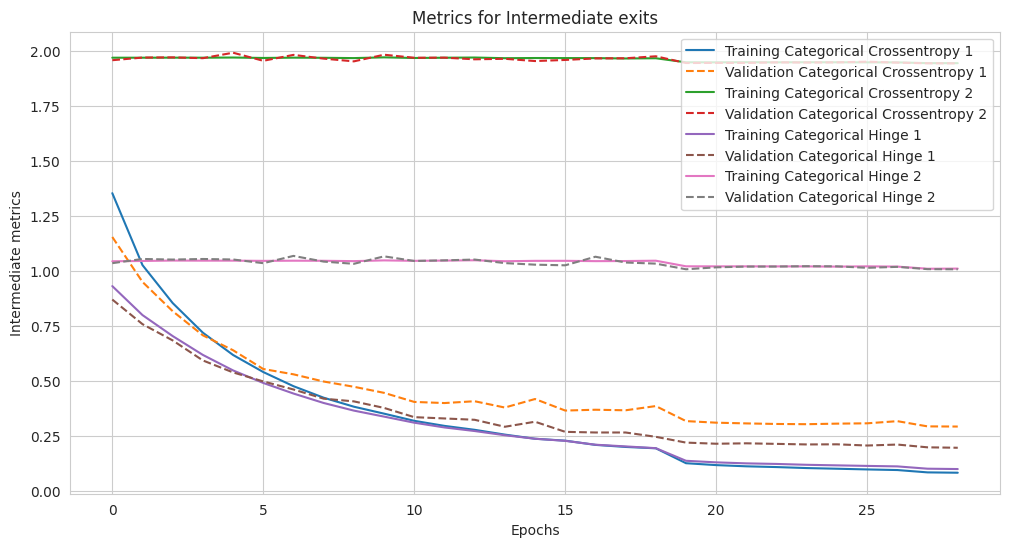

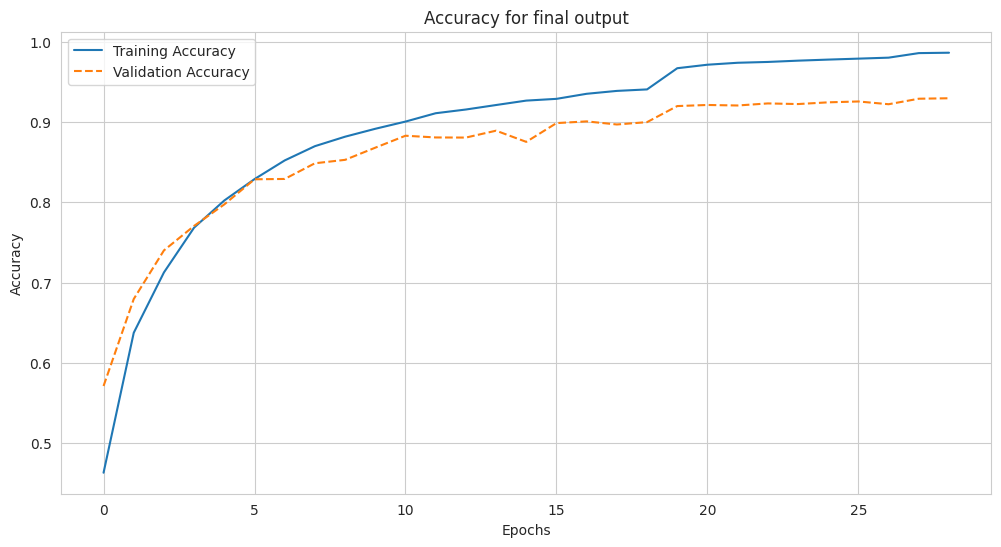

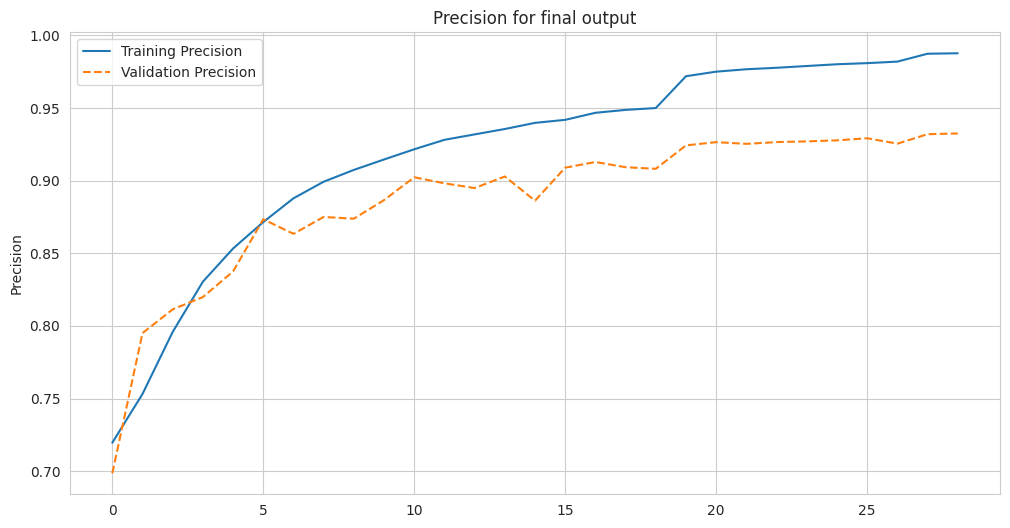

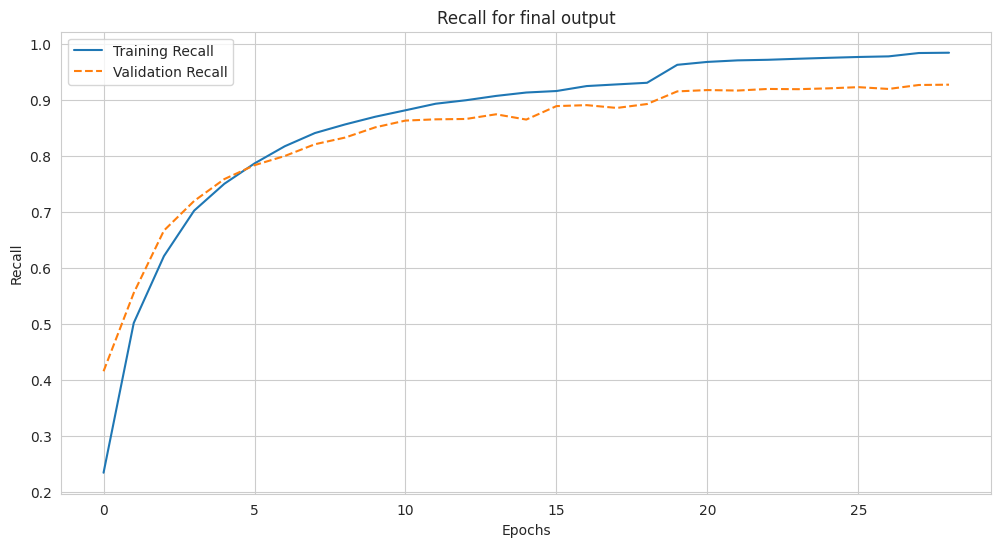

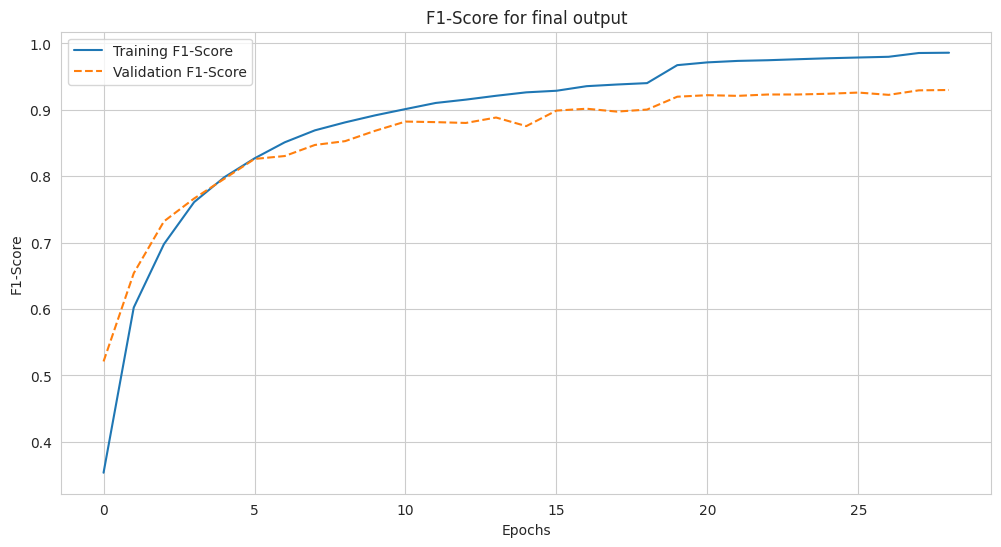

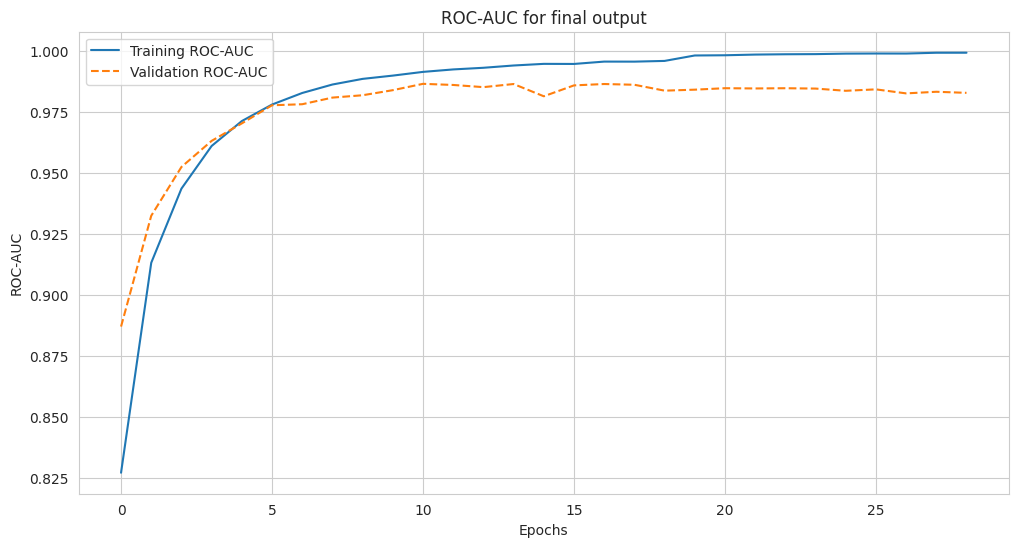

In [56]:
import matplotlib.pyplot as plt
# Extract training history
history_dict = history.history
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history_dict['loss'], label='Total Training Loss')
plt.plot(history_dict['val_loss'], label='Total Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history_dict['student_exit_1_categorical_crossentropy_1'], label='Training Categorical Crossentropy 1')
plt.plot(history_dict['val_student_exit_1_categorical_crossentropy_1'], label='Validation Categorical Crossentropy 1', linestyle='--')
plt.plot(history_dict['student_exit_2_categorical_crossentropy_2'], label='Training Categorical Crossentropy 2')
plt.plot(history_dict['val_student_exit_2_categorical_crossentropy_2'], label='Validation Categorical Crossentropy 2', linestyle='--')
plt.plot(history_dict['student_exit_1_categorical_hinge_1'], label='Training Categorical Hinge 1')
plt.plot(history_dict['val_student_exit_1_categorical_hinge_1'], label='Validation Categorical Hinge 1', linestyle='--')
plt.plot(history_dict['student_exit_2_categorical_hinge_2'], label='Training Categorical Hinge 2')
plt.plot(history_dict['val_student_exit_2_categorical_hinge_2'], label='Validation Categorical Hinge 2', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Intermediate metrics')
plt.title('Metrics for Intermediate exits')
plt.legend()
plt.grid(True)
plt.show()
# Plot training and validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_dict['student_final_output_accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_student_final_output_accuracy'], label='Validation Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy for final output')
plt.legend()
plt.grid(True)
plt.show()
# Plot Precision
plt.figure(figsize=(12, 6))
plt.plot(history_dict['student_final_output_precision'], label='Training Precision')
plt.plot(history_dict['val_student_final_output_precision'], label='Validation Precision', linestyle='--')
plt.ylabel('Precision')
plt.title('Precision for final output')
plt.legend()
plt.grid(True)
plt.show()

# Plot Recall
plt.figure(figsize=(12, 6))
plt.plot(history_dict['student_final_output_recall'], label='Training Recall')
plt.plot(history_dict['val_student_final_output_recall'], label='Validation Recall', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Recall for final output')
plt.legend()
plt.grid(True)
plt.show()

# Plot F1-Score
plt.figure(figsize=(12, 6))
plt.plot(history_dict['student_final_output_f1_score'], label='Training F1-Score')
plt.plot(history_dict['val_student_final_output_f1_score'], label='Validation F1-Score', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.title('F1-Score for final output')
plt.legend()
plt.grid(True)
plt.show()

# Plot ROC-AUC
plt.figure(figsize=(12, 6))
plt.plot(history_dict['student_final_output_roc_auc'], label='Training ROC-AUC')
plt.plot(history_dict['val_student_final_output_roc_auc'], label='Validation ROC-AUC', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC for final output')
plt.legend()
plt.grid(True)
plt.show()

In [57]:
# Evaluate the student model
evaluation_results = student_model.evaluate(
    x_test,  # Test inputs
    {
        'student_exit_1': y_test,  # Targets for exit 1
        'student_exit_2': y_test,  # Targets for exit 2
        'student_final_output': y_test,  # Targets for the final output
    },
    verbose=1
)

438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 2.5750 - student_exit_1_categorical_crossentropy_1: 0.3083 - student_exit_1_categorical_hinge_1: 0.2094 - student_exit_2_categorical_crossentropy_2: 1.9484 - student_exit_2_categorical_hinge_2: 1.0216 - student_final_output_accuracy: 0.9233 - student_final_output_f1_score: 0.9247 - student_final_output_precision: 0.9286 - student_final_output_recall: 0.9208 - student_final_output_roc_auc: 0.9845


438/438 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step


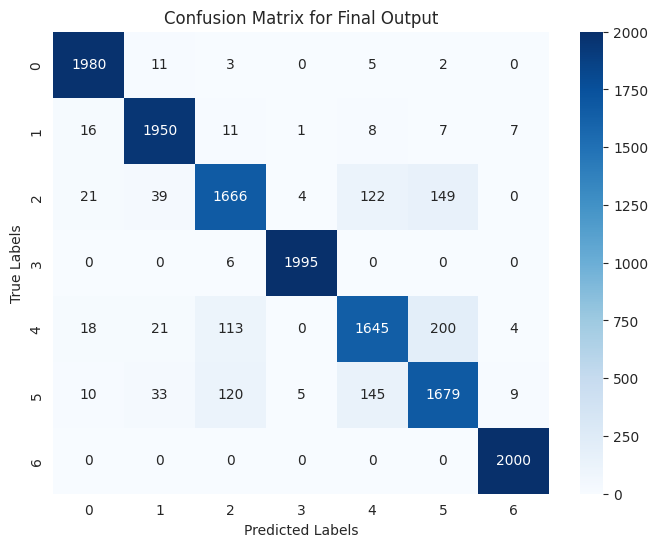

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions for the test dataset
predictions = student_model.predict(x_test, verbose=1)

# Use the final output predictions (last output of the model)
y_pred_final = predictions[-1]  # Access the final output
y_pred_classes = np.argmax(y_pred_final, axis=-1)  # Convert probabilities to class indices

# True labels for final output
y_true_final = np.argmax(y_test, axis=-1)  # Assuming y_test_final is one-hot encoded

# Generate confusion matrix
cm = confusion_matrix(y_true_final, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(cm.shape[1]), 
            yticklabels=np.arange(cm.shape[0]))
plt.title('Confusion Matrix for Final Output')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [59]:
student_model.save("Student.hdf5")